In [ ]:
!pip install minepy
!pip install scikit-optimize
!pip install barplots
!pip install cache_decorator
!pip install extra_keras_metrics
!pip install epigenomic_dataset
!pip install ucsc_genomes_downloader
!pip install keras_bed_sequence
!pip install boruta
!pip install seaborn

     |████████████████████████████████| 495 kB 12.6 MB/s 
  Created wheel for minepy: filename=minepy-1.2.5-cp37-cp37m-linux_x86_64.whl size=177557 sha256=9d12eb0f9a76cc259b31ba36e45569d654335b1c1685d39cdd0137928b7cce3b
  Stored in directory: /root/.cache/pip/wheels/d1/ea/d7/fabbfa6e294adcbc43dabca0e0158dafdd36051246992c7311
Successfully built minepy
     |████████████████████████████████| 101 kB 6.6 MB/s 
  Created wheel for barplots: filename=barplots-1.1.11-py3-none-any.whl size=17877 sha256=7bc2645354eb95113ff910029f6c05cad358c2cc4437a89a67dae9727e29b4fb
  Stored in directory: /root/.cache/pip/wheels/2a/53/e4/1c71fe6cb782f2f43b23872deea5369ad81c11118361558728
  Created wheel for sanitize-ml-labels: filename=sanitize_ml_labels-1.0.26-py3-none-any.whl size=7612 sha256=d068d66e5fbe6389ab9f88ec3cf5821f7590d722019b915db6f05ab70f120efc
  Stored in directory: /root/.cache/pip/wheels/15/65/34/2e11a0da3cf6f112da5c402e01c454be619ff85a0fb38b3018
  Created wheel for compress-json: filename=com

In [ ]:
from epigenomic_dataset import load_epigenomes
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from cache_decorator import Cache
from tqdm.keras import TqdmCallback
from multiprocessing import cpu_count
from barplots import barplots
import matplotlib.pyplot as plt # A standard plotting library
import seaborn as sns

## Data retrieval and Pre-Processing.

In [ ]:
# Retrieving the data
X, y = load_epigenomes(
    cell_line = "H1",
    dataset = "fantom",
    region = "enhancers",
    window_size = 256,
    root = "datasets", # Path where to download data,
    binarize = True,
    max_inactive_tpm_value = 1,
    min_active_tpm_value = 1,
)

The rate between features and samples for enhancers data is: 1091.1206896551723
Nan values report for enhancers data:
In the document there are 1 NaN values out of 3670530 values.
The sample (row) with most values has 1 NaN values out of 58 values.
The feature (column) with most values has 1 NaN values out of 63285 values.
Class 0 ratio = 62570\63285 = 0.9887019040846963
Class 1 ratio = 715\63285 = 0.011298095915303785


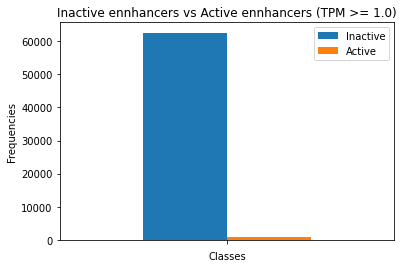

In [ ]:
#Check the rate between features and samples

print(
    f"The rate between features and samples for enhancers data is: {X.shape[0]/X.shape[1]}"
)
print("="*80)

#Check if there are NaN values

print("\n".join((
    f"Nan values report for enhancers data:",
    f"In the document there are {X.isna().values.sum()} NaN values out of {X.values.size} values.",
    f"The sample (row) with most values has {X.isna().sum(axis=0).max()} NaN values out of {X.shape[1]} values.",
    f"The feature (column) with most values has {X.isna().sum().max()} NaN values out of {X.shape[0]} values."
)))
print("="*80)
    
#Check if there is a strong imbalance between the classes
reset_y = y.reset_index()
classes_freq = reset_y["H1"].value_counts()

print("Class 0 ratio = " + str(classes_freq[0]) + "\\" + str(len(reset_y)) + " = " + str(classes_freq[0]/len(reset_y)))
print("Class 1 ratio = " + str(classes_freq[1]) + "\\" + str(len(reset_y)) + " = " + str(classes_freq[1]/len(reset_y)))

plotdata = pd.DataFrame({"Inactive":[classes_freq[0]], "Active": [classes_freq[1]]}, index=['']).plot(kind="bar")
plotdata.set_title("Inactive ennhancers vs Active ennhancers (TPM >= 1.0)")
plotdata.set_xlabel("Classes")
plotdata.set_ylabel("Frequencies")
plt.show()

In [ ]:
# Creating the imputer
imputer = KNNImputer()
# Creating the scaler
scaler = RobustScaler()

# Imputing and scaling the data
X = pd.DataFrame(
    scaler.fit_transform(
        imputer.fit_transform(X)
    ),
    index=X.index,
    columns=X.columns
)

print("\n".join((
    f"Nan values report for enhancers data:",
    f"In the document there are {X.isna().values.sum()} NaN values out of {X.values.size} values.",
    f"The sample (row) with most values has {X.isna().sum(axis=0).max()} NaN values out of {X.shape[1]} values.",
    f"The feature (column) with most values has {X.isna().sum().max()} NaN values out of {X.shape[0]} values."
)))
print("="*80)

Nan values report for enhancers data:
In the document there are 0 NaN values out of 3670530 values.
The sample (row) with most values has 0 NaN values out of 58 values.
The feature (column) with most values has 0 NaN values out of 63285 values.


### Correlation with output and between features
If our features do not have any kind of correlation with the output, we can consider dropping them.
Then we Identify and drop features that have extremely high Pearson correlation scores (more than 0.95 or even 0.99) one-another. 

In [ ]:
from scipy.stats import pearsonr

p_value_threshold = 0.01
correlation_threshold = 0.05

n_top_scores = 5
scores = []
uncorrelated = set()
i = 0
for column in tqdm(X.columns, desc=f"Running Pearson test between features and output", dynamic_ncols=True, leave=False):
    correlation, p_value = pearsonr(X[column].values.ravel(), y.values.ravel())
    scores.append((column, correlation, p_value))
    if p_value > p_value_threshold:
        uncorrelated.add(column)
    i+=1

scores = sorted(scores, key=lambda x: (np.abs(x[1]), p_value), reverse=False)
n = [print(score) for score in scores[:n_top_scores]]

Running Pearson test between features and output:   0%|          | 0/58 [00:00<?, ?it/s]

('RNF2', 0.0027212716986800443, 0.4936186266233416)
('SUZ12', -0.005833402135527622, 0.1422499039843926)
('H3K79me2', 0.007618063736979174, 0.05531052206110753)
('H3K27me3', -0.014340963380037826, 0.00030880420209564635)
('H3K4me1', 0.016556297357969783, 3.110936427803794e-05)


In [ ]:
from scipy.stats import spearmanr

scores = []
for column in tqdm(X.columns, desc=f"Running Spearman test for promoters", dynamic_ncols=True, leave=False):
    correlation, p_value = spearmanr(X[column].values.ravel(), y.values.ravel())
    scores.append((column, correlation, p_value))
    if p_value > p_value_threshold:
        print(column, correlation)
        uncorrelated.add(column)

scores = sorted(scores, key=lambda x: (np.abs(x[1]), p_value), reverse=False)
n = [print(score) for score in scores[:n_top_scores]]

Running Spearman test for promoters:   0%|          | 0/58 [00:00<?, ?it/s]

SUZ12 -0.006942516538202791
RNF2 0.008929446519243501
('SUZ12', -0.006942516538202791, 0.08072733262280245)
('RNF2', 0.008929446519243501, 0.02468239678543564)
('SIX5', 0.014095177028781925, 0.0003911845024656366)
('H3K4me1', 0.019066729822424713, 1.6116807763283442e-06)
('H2AFZ', -0.02197064313792445, 3.246318670111136e-08)


In [ ]:
from minepy import MINE

for column in tqdm(uncorrelated, desc=f"Running MINE test for promoters", dynamic_ncols=True, leave=False):
    mine = MINE()
    correlation, p_value = pearsonr(X[column].values.ravel(), y.values.ravel())
    mine.compute_score(X[column].values.ravel(), y.values.ravel())
    score = mine.mic()
    if score < correlation_threshold:
        print(column, score)
    else:
        uncorrelated.remove(column)

Running MINE test for promoters:   0%|          | 0/3 [00:00<?, ?it/s]

H3K79me2 0.010022475706693118
RNF2 0.006776691994146742
SUZ12 0.004042827691177474


In [ ]:
from scipy.stats import pearsonr
from scipy.stats import entropy

p_value_threshold = 0.01
correlation_threshold = 0.95

extremely_correlated =  set()
n_top_scores = 5

scores = []
for i, column in tqdm(
    enumerate(X.columns),
    total=len(X.columns), desc=f"Running Pearson test for promoters", dynamic_ncols=True, leave=False):
    
    for feature in X.columns[i+1:]:
        correlation, p_value = pearsonr(X[column].values.ravel(), X[feature].values.ravel())
        correlation = np.abs(correlation)
        scores.append((correlation, column, feature, p_value))
        if p_value < p_value_threshold and correlation > correlation_threshold:
            if entropy(X[column]) > entropy(X[feature]):
                extremely_correlated.add(feature)
            else:
                extremely_correlated.add(column)

scores = sorted(scores, key=lambda x: np.abs(x[0]), reverse=True)
print("Most", str(n_top_scores), " correlated features with Pearson Correlation method:")
n = [print(score) for score in scores[:n_top_scores]]
print("Most", str(n_top_scores), " uncorrelated features with Pearson Correlation method:")
n = [print(score) for score in scores[-n_top_scores:]]

Running Pearson test for promoters:   0%|          | 0/58 [00:00<?, ?it/s]

Most 5  correlated features with Pearson Correlation method:
(0.886915239108121, 'POLR2A', 'POLR2AphosphoS5', 0.0)
(0.8780161221412082, 'H3K4me3', 'H3K4me2', 0.0)
(0.8583613081608245, 'CTCF', 'RAD21', 0.0)
(0.8209316138662539, 'SUZ12', 'RNF2', 0.0)
(0.8140772687226926, 'SUZ12', 'H3K27me3', 0.0)
Most 5  uncorrelated features with Pearson Correlation method:
(0.0009963821559394173, 'H3K9me3', 'H4K20me1', 0.8020846522486882)
(0.0008397369423785309, 'H3K79me2', 'REST', 0.832696587030786)
(0.0006135472995460788, 'TAF1', 'H3K27me3', 0.8773384632415357)
(0.0005586583148192901, 'H3K36me3', 'H3K9ac', 0.8882363762304071)
(0.0003427320406239262, 'JUND', 'H3K79me2', 0.9312933447053859)


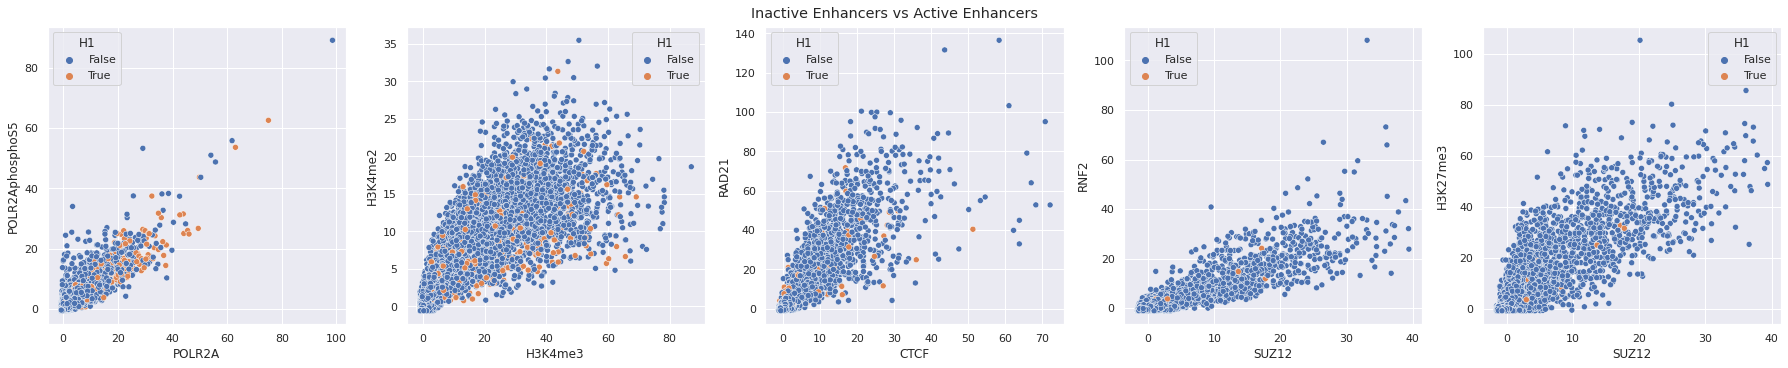

In [ ]:
top_scores = scores[:n_top_scores]
data = pd.concat([X, y], axis = 1)
sns.set(rc={'figure.figsize':(25,5)})

fig, axs = plt.subplots(ncols=n_top_scores)
i = 0
for i, score in enumerate(top_scores):
  sns.scatterplot(x = score[1], y = score[2], data = data, hue=y.columns[0],  ax=axs[i])

fig.suptitle("Inactive Enhancers vs Active Enhancers", va = "bottom")
plt.tight_layout()

### Visualisation of the distributions

Top 5 different features from enhancers.


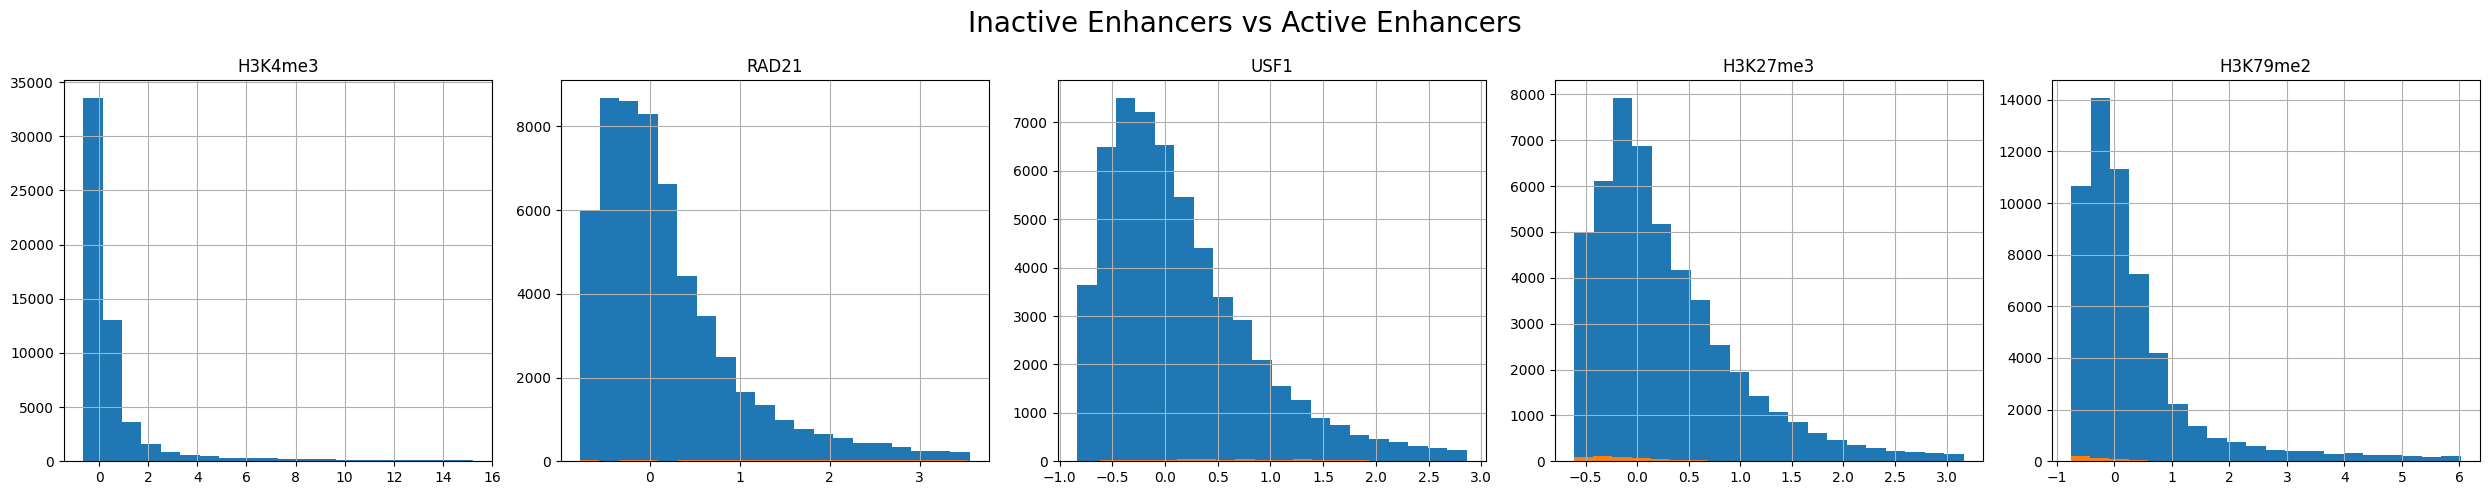

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

def get_top_most_different(dist, n:int):
    return np.argsort(-np.mean(dist, axis=1).flatten())[:n]

top_number = 5

dist = euclidean_distances(X.T)
most_distance_columns_indices = get_top_most_different(dist, top_number)
columns = X.columns[most_distance_columns_indices]
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 5))
print(f"Top {top_number} different features from enhancers.")
for column, axis in zip(columns, axes.flatten()):
    head, tail = X[column].quantile([0.05, 0.95]).values.ravel()

    mask = ((X[column] < tail) & (X[column] > head)).values

    cleared_X = X[column][mask]
    cleared_y = y.values.ravel()[mask]

    cleared_X[cleared_y==0].hist(ax=axis, bins=20)
    cleared_X[cleared_y==1].hist(ax=axis, bins=20)

    axis.set_title(column)
fig.suptitle('Inactive Enhancers vs Active Enhancers (TPM >= 1.0)', fontsize=20)
fig.tight_layout()
plt.show()

### Visualisation of the data by PCA decomposition

In [ ]:
from sklearn.decomposition import PCA

def pca(x:np.ndarray, n_components:int=2)->np.ndarray:
    return PCA(n_components=n_components, random_state=42).fit_transform(x)

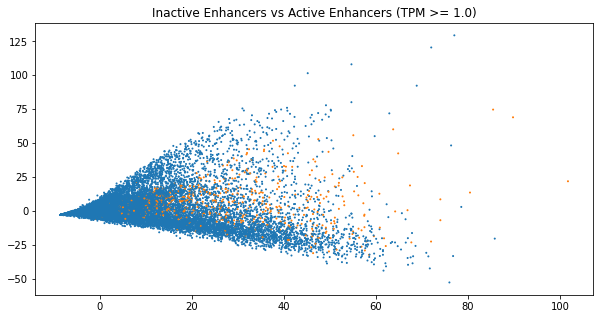

In [ ]:
from sklearn.decomposition import PCA
colors = np.array([
    "tab:blue",
    "tab:orange",
])

xseries = []
yseries = []
for example in pca(X):
    xseries.append(example[0])
    yseries.append(example[1])

tcolors = []
for color in colors[y.values.astype(int)]:
    tcolors.append(color[0])

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
axes.scatter(xseries, yseries, s=1, c=tcolors)
axes.set_title(f"Inactive Enhancers vs Active Enhancers (TPM >= 1.0)")
plt.show()

## Feature selection
We will execute a feature selection step in each one of the holdouts, using the training data of the holdout. Otherwise, if we were to use all data, we would induce a possible positive bias in the model performance since we would use also data that we reserve to evaluate the models performance.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
from multiprocessing import cpu_count

def execute_boruta_feature_selection(
    X_train: pd.DataFrame,
    y_train: np.ndarray,
    holdout_number: int,
    max_iter: int = 200,
    verbose: int = 2
):
    """Returns tuple with list of kept features and list of discared features.
    
    Parameters
    --------------------------
    X_train: pd.DataFrame,
        The data reserved for the input of the training of the Boruta model.
    y_train: np.ndarray,
        The data reserved for the output of the training of the Boruta model.
    holdout_number: int,
        The current holdout number.
    max_iter: int = 100,
        Number of iterations to run Boruta for.
    """
    # Create the Boruta model
    boruta_selector = BorutaPy(
        # Defining the model that Boruta should use.
        RandomForestClassifier(n_jobs=cpu_count(), class_weight='balanced_subsample', max_depth=5),
        # We leave the number of estimators to be decided by Boruta
        n_estimators='auto',
        verbose=verbose,
        alpha=0.05, # p_value
        # In practice one would run at least 100-200 times,
        # until all tentative features are exausted.
        max_iter=max_iter, 
        random_state=42,
    )
    # Fit the Boruta model
    boruta_selector.fit(X_train.values, y_train)
    
    # Get the kept features and discarded features
    kept_features = list(X_train.columns[boruta_selector.support_])
    discarded_features = list(X_train.columns[~boruta_selector.support_])
    
    # Filter out the unused featured.
    return kept_features, discarded_features

In [ ]:
#I've done this because I wanted to see if with all the dataset there was some features rejected
kept_features, discarded_features = execute_boruta_feature_selection(X, y.values.ravel(), 1)

Iteration: 	1 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	2 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	3 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	4 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	5 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	6 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	7 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	8 / 200
Confirmed: 	38
Tentative: 	20
Rejected: 	0
Iteration: 	9 / 200
Confirmed: 	38
Tentative: 	20
Rejected: 	0
Iteration: 	10 / 200
Confirmed: 	38
Tentative: 	20
Rejected: 	0
Iteration: 	11 / 200
Confirmed: 	38
Tentative: 	19
Rejected: 	1
Iteration: 	12 / 200
Confirmed: 	46
Tentative: 	11
Rejected: 	1
Iteration: 	13 / 200
Confirmed: 	46
Tentative: 	11
Rejected: 	1
Iteration: 	14 / 200
Confirmed: 	46
Tentative: 	11
Rejected: 	1
Iteration: 	15 / 200
Confirmed: 	46
Tentative: 	11
Rejected: 	1
Iteration: 	16 / 200
Confirmed: 	49
Tentative: 	8
Reject

### FFNN
We define a method to create and train a FFNN model:

### BAYESIAN OPTIMIZATION

In [ ]:
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.plots import plot_objective
from skopt.utils import use_named_args

In [ ]:
#Definition of the dimensions in which we want to find the best hyper parameter's values for the task.
dim_learning_rate = Categorical(categories=[1e-06, 1e-05, 1e-04, 1e-03, 1e-02, 1e-01],
                         name='learning_rate')
dim_regularization_factor = Categorical(categories=[1e-06, 1e-05, 1e-04, 1e-03, 1e-02, 1e-01],
                         name='l2_regularization_factor')
dim_num_dense_layers = Integer(low=1, high=3, 
                               name='num_dense_layers')
dim_num_dense_nodes_3 = Categorical(categories=[128, 256, 512],  
                                    name='num_dense_nodes_3')
dim_num_dense_nodes_2 = Categorical(categories=[64, 128, 256],  
                                    name='num_dense_nodes_2')
dim_num_dense_nodes_1 = Categorical(categories=[16, 32, 64, 128], name=
                                    'num_dense_nodes_1')

dimensions = [dim_learning_rate,
              dim_num_dense_layers,
              dim_num_dense_nodes_3,
              dim_num_dense_nodes_2,
              dim_num_dense_nodes_1,
              dim_regularization_factor]

In [ ]:
from tensorflow.keras.layers import Dense, InputLayer, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import AUC, Accuracy

from tensorflow.keras.optimizers import Adam

def create_model(X_train: np.ndarray, 
    learning_rate, 
    num_dense_layers,
    num_dense_nodes_3,             
    num_dense_nodes_2,
    num_dense_nodes_1,
    l2_regularization_factor):
    
    model = Sequential()

    model.add(InputLayer(input_shape=(X_train.shape[1])))
    
    #Composition of the 3th layer
    if num_dense_layers == 3:
        name = 'layer_dense_3'
        model.add(Dense(num_dense_nodes_3,
                        activation='relu',
                        kernel_regularizer=l2(l2_regularization_factor), #I put the same regularization_factor 
                                                                         #to all the dense layers;
                        name=name))
        
    #Composition of the 2th layer
    if num_dense_layers >= 2:
        name = 'layer_dense_2'
        model.add(Dense(num_dense_nodes_2,
                        activation='relu',
                        kernel_regularizer=l2(l2_regularization_factor),
                        name=name))
        
    #Composition of the 1th layer
    name = 'layer_dense_1'
    model.add(Dense(num_dense_nodes_1,
                activation='relu',
                kernel_regularizer=l2(l2_regularization_factor),
                name=name))


    # use softmax-activation for classification.
    model.add(Dense(1, activation='sigmoid'))
    
    # Use the Adam method for training the network.
    optimizer = Adam(lr=learning_rate)
    
    #compile the model so it can be trained.
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy', AUC(curve='ROC', name='AUROC'),  AUC(curve='PR', name='AUPRC')])
    return model

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

number_of_splits = 1
holdouts_generator = StratifiedShuffleSplit(
    n_splits=number_of_splits,
    test_size=0.2,
    random_state = 42
)

for holdout_number, (train_indices, test_indices) in enumerate(holdouts_generator.split(X, y)):
    X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
    y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]

In [ ]:
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import backend as K

@use_named_args(dimensions=dimensions)
def fitness(learning_rate, num_dense_layers,
            num_dense_nodes_3, num_dense_nodes_2, num_dense_nodes_1, l2_regularization_factor):
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    num_dense_layers:  Number of dense layers.
    num_dense_nodes:   Number of nodes in each dense layer.
    l2_regularization_factor:        Activation function for all layers.
    """

    # Print the hyper-parameters.
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('num_dense_layers:', num_dense_layers)
    print('num_dense_nodes_3:', num_dense_nodes_3)
    print('num_dense_nodes_2:', num_dense_nodes_2)
    print('num_dense_nodes_1:', num_dense_nodes_1)
    print('l2_regularization_factor:', l2_regularization_factor)

    
    # Create the neural network with these hyper-parameters.
    model = create_model(X_train = X_train,
                         learning_rate=learning_rate,
                         num_dense_layers=num_dense_layers,
                         num_dense_nodes_1=num_dense_nodes_1,
                         num_dense_nodes_2=num_dense_nodes_2,
                         num_dense_nodes_3=num_dense_nodes_3,
                         l2_regularization_factor=l2_regularization_factor)
    
   
    # Training phase
    history = model.fit(x= X_train,
                        y= y_train,
                        epochs=15,
                        batch_size=128,
                        validation_data=(X_test, y_test),
                        callbacks = [EarlyStopping(monitor = "val_loss", patience = 2)])

    # I use this metric because I want to put more importance to the positive examples
    val_loss = history.history['val_loss'][-1]

    # Print the result of the AUPRC metric over the validation set.
    print()
    print("val_loss: {0:.2%}".format(val_loss))
    print()

    del model
    K.clear_session()
    
    # Scikit-optimize does minimization so it tries to
    # find a set of hyper-parameters with the LOWEST fitness-value.
    # We need to negate the result so it can be minimized.
    return val_loss


In [ ]:
%%time

default_parameters = [0.1, 3, 256, 128, 64, 0.001]
search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            acq_func='EI', # Expected Improvement.
                            n_calls=40,
                            x0=default_parameters)

learning rate: 1.0e-01
num_dense_layers: 3
num_dense_nodes_3: 256
num_dense_nodes_2: 128
num_dense_nodes_1: 64
l2_regularization_factor: 0.001
Epoch 1/15
396/396 [==============================] - 1s 4ms/step - loss: 1.8098 - accuracy: 0.9864 - AUROC: 0.7499 - AUPRC: 0.0264 - val_loss: 0.1438 - val_accuracy: 0.9887 - val_AUROC: 0.9043 - val_AUPRC: 0.1016
Epoch 2/15
396/396 [==============================] - 1s 2ms/step - loss: 0.1206 - accuracy: 0.9884 - AUROC: 0.8133 - AUPRC: 0.0804 - val_loss: 0.0733 - val_accuracy: 0.9887 - val_AUROC: 0.8952 - val_AUPRC: 0.0740
Epoch 3/15
396/396 [==============================] - 1s 2ms/step - loss: 0.0665 - accuracy: 0.9887 - AUROC: 0.8393 - AUPRC: 0.0836 - val_loss: 0.0492 - val_accuracy: 0.9887 - val_AUROC: 0.8990 - val_AUPRC: 0.1596
Epoch 4/15
396/396 [==============================] - 1s 3ms/step - loss: 0.0545 - accuracy: 0.9887 - AUROC: 0.8507 - AUPRC: 0.1159 - val_loss: 0.0485 - val_accuracy: 0.9887 - val_AUROC: 0.9254 - val_AUPRC: 0.1272
E

396/396 [==============================] - 1s 2ms/step - loss: 0.5342 - accuracy: 0.8239 - AUROC: 0.2481 - AUPRC: 0.0091 - val_loss: 0.4966 - val_accuracy: 0.8809 - val_AUROC: 0.1938 - val_AUPRC: 0.0073
Epoch 4/15
396/396 [==============================] - 1s 2ms/step - loss: 0.4545 - accuracy: 0.9166 - AUROC: 0.1871 - AUPRC: 0.0072 - val_loss: 0.4296 - val_accuracy: 0.9462 - val_AUROC: 0.1613 - val_AUPRC: 0.0062
Epoch 5/15
396/396 [==============================] - 1s 2ms/step - loss: 0.3948 - accuracy: 0.9599 - AUROC: 0.1747 - AUPRC: 0.0064 - val_loss: 0.3771 - val_accuracy: 0.9717 - val_AUROC: 0.1489 - val_AUPRC: 0.0061
Epoch 6/15
396/396 [==============================] - 1s 2ms/step - loss: 0.3471 - accuracy: 0.9781 - AUROC: 0.1711 - AUPRC: 0.0064 - val_loss: 0.3339 - val_accuracy: 0.9825 - val_AUROC: 0.1548 - val_AUPRC: 0.0062
Epoch 7/15
396/396 [==============================] - 1s 2ms/step - loss: 0.3077 - accuracy: 0.9844 - AUROC: 0.1787 - AUPRC: 0.0066 - val_loss: 0.2977 - va

Epoch 10/15
396/396 [==============================] - 1s 2ms/step - loss: 0.0434 - accuracy: 0.9896 - AUROC: 0.8810 - AUPRC: 0.3593 - val_loss: 0.0493 - val_accuracy: 0.9875 - val_AUROC: 0.8937 - val_AUPRC: 0.2866
Epoch 11/15
396/396 [==============================] - 1s 2ms/step - loss: 0.0419 - accuracy: 0.9897 - AUROC: 0.8898 - AUPRC: 0.3770 - val_loss: 0.0477 - val_accuracy: 0.9885 - val_AUROC: 0.8957 - val_AUPRC: 0.2884
Epoch 12/15
396/396 [==============================] - 1s 2ms/step - loss: 0.0406 - accuracy: 0.9897 - AUROC: 0.9000 - AUPRC: 0.3909 - val_loss: 0.0463 - val_accuracy: 0.9889 - val_AUROC: 0.8950 - val_AUPRC: 0.2972
Epoch 13/15
396/396 [==============================] - 1s 2ms/step - loss: 0.0394 - accuracy: 0.9900 - AUROC: 0.9057 - AUPRC: 0.4066 - val_loss: 0.0452 - val_accuracy: 0.9888 - val_AUROC: 0.9047 - val_AUPRC: 0.2873
Epoch 14/15
396/396 [==============================] - 1s 2ms/step - loss: 0.0383 - accuracy: 0.9902 - AUROC: 0.9117 - AUPRC: 0.4289 - val_l


val_loss: 38.59%

learning rate: 1.0e-01
num_dense_layers: 3
num_dense_nodes_3: 128
num_dense_nodes_2: 256
num_dense_nodes_1: 16
l2_regularization_factor: 1e-06
Epoch 1/15
396/396 [==============================] - 2s 5ms/step - loss: 2.1123 - accuracy: 0.9859 - AUROC: 0.5290 - AUPRC: 0.0123 - val_loss: 0.0752 - val_accuracy: 0.9887 - val_AUROC: 0.5152 - val_AUPRC: 0.0116
Epoch 2/15
396/396 [==============================] - 1s 3ms/step - loss: 0.0734 - accuracy: 0.9887 - AUROC: 0.5229 - AUPRC: 0.0118 - val_loss: 0.0709 - val_accuracy: 0.9887 - val_AUROC: 0.5231 - val_AUPRC: 0.0118
Epoch 3/15
396/396 [==============================] - 1s 3ms/step - loss: 0.0725 - accuracy: 0.9886 - AUROC: 0.5010 - AUPRC: 0.0113 - val_loss: 0.0701 - val_accuracy: 0.9887 - val_AUROC: 0.5141 - val_AUPRC: 0.0116
Epoch 4/15
396/396 [==============================] - 1s 3ms/step - loss: 0.0896 - accuracy: 0.9887 - AUROC: 0.5279 - AUPRC: 0.0120 - val_loss: 0.0867 - val_accuracy: 0.9887 - val_AUROC: 0.5000 - 

396/396 [==============================] - 1s 2ms/step - loss: 0.0596 - accuracy: 0.9886 - AUROC: 0.8635 - AUPRC: 0.0722 - val_loss: 0.0562 - val_accuracy: 0.9887 - val_AUROC: 0.8696 - val_AUPRC: 0.0828
Epoch 5/15
396/396 [==============================] - 1s 2ms/step - loss: 0.0614 - accuracy: 0.9886 - AUROC: 0.8638 - AUPRC: 0.0661 - val_loss: 0.0557 - val_accuracy: 0.9887 - val_AUROC: 0.8719 - val_AUPRC: 0.0850
Epoch 6/15
396/396 [==============================] - 1s 2ms/step - loss: 0.0648 - accuracy: 0.9886 - AUROC: 0.8567 - AUPRC: 0.0686 - val_loss: 0.0684 - val_accuracy: 0.9887 - val_AUROC: 0.8721 - val_AUPRC: 0.0517
Epoch 7/15
396/396 [==============================] - 1s 2ms/step - loss: 0.0630 - accuracy: 0.9886 - AUROC: 0.8647 - AUPRC: 0.0678 - val_loss: 0.0551 - val_accuracy: 0.9887 - val_AUROC: 0.8984 - val_AUPRC: 0.0838
Epoch 8/15
396/396 [==============================] - 1s 2ms/step - loss: 0.0585 - accuracy: 0.9886 - AUROC: 0.8686 - AUPRC: 0.0764 - val_loss: 0.0514 - va

396/396 [==============================] - 2s 5ms/step - loss: 0.4754 - accuracy: 0.9873 - AUROC: 0.1511 - AUPRC: 0.0073 - val_loss: 0.4454 - val_accuracy: 0.9887 - val_AUROC: 0.1174 - val_AUPRC: 0.0060
Epoch 3/15
396/396 [==============================] - 2s 5ms/step - loss: 0.4142 - accuracy: 0.9887 - AUROC: 0.1323 - AUPRC: 0.0060 - val_loss: 0.3939 - val_accuracy: 0.9887 - val_AUROC: 0.1121 - val_AUPRC: 0.0060
Epoch 4/15
396/396 [==============================] - 2s 4ms/step - loss: 0.3671 - accuracy: 0.9887 - AUROC: 0.1261 - AUPRC: 0.0060 - val_loss: 0.3524 - val_accuracy: 0.9887 - val_AUROC: 0.1131 - val_AUPRC: 0.0060
Epoch 5/15
396/396 [==============================] - 2s 5ms/step - loss: 0.3282 - accuracy: 0.9887 - AUROC: 0.1232 - AUPRC: 0.0060 - val_loss: 0.3177 - val_accuracy: 0.9887 - val_AUROC: 0.1178 - val_AUPRC: 0.0060
Epoch 6/15
396/396 [==============================] - 2s 5ms/step - loss: 0.2954 - accuracy: 0.9887 - AUROC: 0.1271 - AUPRC: 0.0061 - val_loss: 0.2880 - va

396/396 [==============================] - 1s 3ms/step - loss: 0.0702 - accuracy: 0.9886 - AUROC: 0.5578 - AUPRC: 0.0130 - val_loss: 0.0697 - val_accuracy: 0.9887 - val_AUROC: 0.5000 - val_AUPRC: 0.0113
Epoch 6/15
396/396 [==============================] - 1s 2ms/step - loss: 0.0686 - accuracy: 0.9887 - AUROC: 0.4913 - AUPRC: 0.0111 - val_loss: 0.0677 - val_accuracy: 0.9887 - val_AUROC: 0.5000 - val_AUPRC: 0.0113
Epoch 7/15
396/396 [==============================] - 1s 2ms/step - loss: 0.0672 - accuracy: 0.9887 - AUROC: 0.5001 - AUPRC: 0.0112 - val_loss: 0.0665 - val_accuracy: 0.9887 - val_AUROC: 0.5000 - val_AUPRC: 0.0113
Epoch 8/15
396/396 [==============================] - 1s 2ms/step - loss: 0.0659 - accuracy: 0.9887 - AUROC: 0.5018 - AUPRC: 0.0113 - val_loss: 0.0655 - val_accuracy: 0.9887 - val_AUROC: 0.5000 - val_AUPRC: 0.0113
Epoch 9/15
396/396 [==============================] - 1s 3ms/step - loss: 0.0652 - accuracy: 0.9887 - AUROC: 0.5020 - AUPRC: 0.0118 - val_loss: 0.0647 - va

396/396 [==============================] - 1s 2ms/step - loss: 0.1137 - accuracy: 0.9883 - AUROC: 0.7869 - AUPRC: 0.0849 - val_loss: 0.2445 - val_accuracy: 0.9887 - val_AUROC: 0.6992 - val_AUPRC: 0.0447
Epoch 4/15
396/396 [==============================] - 1s 2ms/step - loss: 0.1028 - accuracy: 0.9887 - AUROC: 0.8136 - AUPRC: 0.1002 - val_loss: 0.0899 - val_accuracy: 0.9887 - val_AUROC: 0.9318 - val_AUPRC: 0.2124

val_loss: 8.99%

learning rate: 1.0e-05
num_dense_layers: 3
num_dense_nodes_3: 256
num_dense_nodes_2: 64
num_dense_nodes_1: 16
l2_regularization_factor: 0.0001
Epoch 1/15
396/396 [==============================] - 2s 5ms/step - loss: 0.5847 - accuracy: 0.8386 - AUROC: 0.3028 - AUPRC: 0.0352 - val_loss: 0.4858 - val_accuracy: 0.9810 - val_AUROC: 0.1448 - val_AUPRC: 0.0133
Epoch 2/15
396/396 [==============================] - 1s 3ms/step - loss: 0.4131 - accuracy: 0.9874 - AUROC: 0.1518 - AUPRC: 0.0062 - val_loss: 0.3517 - val_accuracy: 0.9886 - val_AUROC: 0.1476 - val_AUPRC: 0

396/396 [==============================] - 2s 5ms/step - loss: 0.0463 - accuracy: 0.9894 - AUROC: 0.8744 - AUPRC: 0.3274 - val_loss: 0.0543 - val_accuracy: 0.9885 - val_AUROC: 0.8398 - val_AUPRC: 0.2244
Epoch 4/15
396/396 [==============================] - 2s 5ms/step - loss: 0.0410 - accuracy: 0.9894 - AUROC: 0.8933 - AUPRC: 0.3565 - val_loss: 0.0455 - val_accuracy: 0.9887 - val_AUROC: 0.8832 - val_AUPRC: 0.3030
Epoch 5/15
396/396 [==============================] - 2s 5ms/step - loss: 0.0378 - accuracy: 0.9899 - AUROC: 0.9124 - AUPRC: 0.4093 - val_loss: 0.0429 - val_accuracy: 0.9885 - val_AUROC: 0.9037 - val_AUPRC: 0.2893
Epoch 6/15
396/396 [==============================] - 2s 5ms/step - loss: 0.0354 - accuracy: 0.9905 - AUROC: 0.9254 - AUPRC: 0.4481 - val_loss: 0.0401 - val_accuracy: 0.9896 - val_AUROC: 0.9132 - val_AUPRC: 0.3341
Epoch 7/15
396/396 [==============================] - 2s 5ms/step - loss: 0.0337 - accuracy: 0.9903 - AUROC: 0.9331 - AUPRC: 0.4724 - val_loss: 0.0425 - va

Epoch 15/15
396/396 [==============================] - 1s 2ms/step - loss: 0.0571 - accuracy: 0.9894 - AUROC: 0.9201 - AUPRC: 0.3633 - val_loss: 0.0552 - val_accuracy: 0.9885 - val_AUROC: 0.9377 - val_AUPRC: 0.3359

val_loss: 5.52%

learning rate: 1.0e-06
num_dense_layers: 3
num_dense_nodes_3: 256
num_dense_nodes_2: 64
num_dense_nodes_1: 16
l2_regularization_factor: 1e-06
Epoch 1/15
396/396 [==============================] - 2s 5ms/step - loss: 0.8279 - accuracy: 0.5410 - AUROC: 0.6416 - AUPRC: 0.0649 - val_loss: 0.7571 - val_accuracy: 0.6129 - val_AUROC: 0.6162 - val_AUPRC: 0.0711
Epoch 2/15
396/396 [==============================] - 1s 3ms/step - loss: 0.6983 - accuracy: 0.6748 - AUROC: 0.5225 - AUPRC: 0.0514 - val_loss: 0.6459 - val_accuracy: 0.7393 - val_AUROC: 0.4938 - val_AUPRC: 0.0532
Epoch 3/15
396/396 [==============================] - 1s 3ms/step - loss: 0.6043 - accuracy: 0.7927 - AUROC: 0.4081 - AUPRC: 0.0343 - val_loss: 0.5687 - val_accuracy: 0.8400 - val_AUROC: 0.3824 - v

E:\anaconda\envs\cazzo_culo\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


learning rate: 1.0e-04
num_dense_layers: 1
num_dense_nodes_3: 512
num_dense_nodes_2: 256
num_dense_nodes_1: 128
l2_regularization_factor: 0.01
Epoch 1/15
396/396 [==============================] - 1s 4ms/step - loss: 1.0542 - accuracy: 0.9386 - AUROC: 0.3080 - AUPRC: 0.0234 - val_loss: 0.8254 - val_accuracy: 0.9878 - val_AUROC: 0.4377 - val_AUPRC: 0.0617
Epoch 2/15
396/396 [==============================] - 1s 2ms/step - loss: 0.6988 - accuracy: 0.9880 - AUROC: 0.4760 - AUPRC: 0.0909 - val_loss: 0.5929 - val_accuracy: 0.9878 - val_AUROC: 0.6239 - val_AUPRC: 0.1699
Epoch 3/15
396/396 [==============================] - 1s 2ms/step - loss: 0.5126 - accuracy: 0.9882 - AUROC: 0.5736 - AUPRC: 0.1406 - val_loss: 0.4425 - val_accuracy: 0.9882 - val_AUROC: 0.6573 - val_AUPRC: 0.1954
Epoch 4/15
396/396 [==============================] - 1s 2ms/step - loss: 0.3872 - accuracy: 0.9885 - AUROC: 0.6290 - AUPRC: 0.1692 - val_loss: 0.3382 - val_accuracy: 0.9882 - val_AUROC: 0.7262 - val_AUPRC: 0.2404
E

In [ ]:
results = pd.DataFrame(sorted(zip(search_result.func_vals, search_result.x_iters)))
results.to_csv("best_models_enhancers_1.0_ffnn.csv")

In [ ]:
results

,0,1
0,0.038144,"[0.01, 2, 128, 128, 32, 1e-06]"
1,0.038250,"[0.001, 2, 512, 64, 32, 0.001]"
2,0.039047,"[0.01, 1, 128, 128, 32, 1e-06]"
3,0.039157,"[0.0001, 3, 128, 256, 16, 1e-06]"
4,0.040215,"[0.001, 2, 256, 64, 64, 0.001]"
5,0.040569,"[0.001, 3, 512, 256, 16, 0.0001]"
6,0.041737,"[0.01, 2, 256, 64, 64, 0.001]"
7,0.043741,"[0.0001, 2, 256, 128, 32, 1e-05]"
8,0.044590,"[0.001, 3, 256, 64, 16, 0.01]"
9,0.044783,"[0.0001, 3, 512, 256, 128, 1e-06]"


In [ ]:
best_configuration = results[1][0]

In [ ]:
op_learning_rate = best_configuration[0]
op_num_dense_layers = best_configuration[1]
op_num_of_nodes_3 = best_configuration[2]
op_num_of_nodes_2 = best_configuration[3]
op_num_of_nodes_1 = best_configuration[4]
op_l2_regularization = best_configuration[5]


### Training of the FFNN 
with the best hyper parameter configuration obtained by the Bayesian Optimization procedure

In [ ]:
from typing import Dict
from sanitize_ml_labels import sanitize_ml_labels
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score


def evaluate_model_prediction(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    """Return the evaluation of the given predictions.
    
    Parameters
    ---------------------
    y_true: np.ndarray,
        The ground truth labels.
    y_pred: np.ndarray,
        The predicted labels.
    
    Raises
    ---------------------
    ValueError,
        If the two given numpy arrays do not have the same shape.
    
    Returns
    ---------------------
    Dictionary with the performance metrics
    """
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    if y_true.shape != y_pred.shape:
        raise ValueError(
            "The two arrays do not have the same shape: {} != {}".format(
                y_true.shape, y_pred.shape
            )
        )
    float_metrics = average_precision_score, roc_auc_score
    int_metrics = (accuracy_score, )
    return {
        ** {
            sanitize_ml_labels(metric.__name__): metric(y_true, y_pred)
            for metric in float_metrics
        },
        ** {
            sanitize_ml_labels(metric.__name__): metric(y_true, np.round(y_pred).astype(int))
            for metric in int_metrics
        }
    }

In [ ]:
def evaluate_all_model_prediction(
    y_train_true: np.ndarray,
    y_train_pred: np.ndarray,
    y_test_true: np.ndarray,
    y_test_pred: np.ndarray,
    model_name: str,
    holdout_number: int,
    use_feature_selection: bool
) -> Dict[str, float]:
    """Return the evaluation of the given predictions.
    
    Parameters
    ---------------------
    y_train_true: np.ndarray,
        Ground truth labels used during training.
    y_train_pred: np.ndarray,
        Training predictions
    y_test_true: np.ndarray,
        Ground truth labels used for test.
    y_test_pred: np.ndarray,
        Test predictions
    model_name: str,
        Name of the model used.
    holdout_number: int,
        Number of the holdout.
    use_feature_selection: bool,
        Whether the model is trained using features that have
        been selected with Boruta or not.
    
    Returns
    ---------------------
    Dictionary with the performance metrics
    """
    common_informations = {
        "model_name": model_name,
        "holdout_number": holdout_number,
        "use_feature_selection": use_feature_selection
    }
    return [
        {
            **evaluate_model_prediction(y_train_true, y_train_pred),
            "run_type": "train",
            **common_informations,
        },
        {
            **evaluate_model_prediction(y_test_true, y_test_pred),
            "run_type": "test",
            **common_informations,
        },
    ]

In [ ]:
from tensorflow.keras.layers import Dense, InputLayer, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.regularizers import l2
from extra_keras_metrics import get_standard_binary_metrics
from tensorflow.keras.optimizers import Adam

def train_ffnn(
    X_train: np.ndarray,
    X_test: np.ndarray,
    y_train: np.ndarray,
    y_test: np.ndarray,
    holdout_number: int,
    use_feature_selection: bool
) :
    """Return performance of a FFNN.
    
    Parameters
    ----------------------
    X_train: np.ndarray,
        Data reserved for the input during training of the model.
    X_test: np.ndarray,
        Data reserved for the input during  test of the model.
    y_train: np.ndarray,
        Data reserved for the output during  training of the model.
    y_test: np.ndarray,
        Data reserved for the output during  test of the model.
    holdout_number: int,
        Number of the holdout.
    use_feature_selection: bool,
        Whether the model is trained using features that have
        been selected with Boruta or not.
        
    Returns
    ----------------------
    Dictionary with the model perfomance.
    """
    model = Sequential()
        
    #Composition of the 3th layer
    if op_num_dense_layers == 3:
        name = 'layer_dense_3'
        model.add(Dense(op_num_of_nodes_2,
                        activation='relu',
                        kernel_regularizer=l2(op_l2_regularization), #I put the same regularization_factor 
                                                                         #to all the dense layers;
                        name=name))
        
    #Composition of the 2th layer
    if op_num_dense_layers >= 2:
        name = 'layer_dense_2'
        model.add(Dense(op_num_of_nodes_2,
                        activation='relu',
                        kernel_regularizer=l2(op_l2_regularization),
                        name=name))
        
    #Composition of the 1th layer
    name = 'layer_dense_1'
    model.add(Dense(op_num_of_nodes_1,
                activation='relu',
                kernel_regularizer=l2(op_l2_regularization),
                name=name))


    # use softmax-activation for classification.
    model.add(Dense(1, activation='sigmoid'))
    
    
    model.compile(
        loss="binary_crossentropy",
        optimizer=Adam(learning_rate=op_learning_rate),
        metrics=get_standard_binary_metrics()
    )
    model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=1000,
        batch_size=128,
        verbose=False,
        
        callbacks=[
            EarlyStopping(monitor = "val_loss", patience = 2),
            TqdmCallback(verbose=1)
        ]
    )
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    return evaluate_all_model_prediction(
        y_train, y_train_pred, y_test, y_test_pred,
        "FFNN", holdout_number, use_feature_selection
    )

In [ ]:
# Create a list to store all the computed performance
all_performance = []
number_of_splits = 10
holdouts_generator = StratifiedShuffleSplit(
    n_splits=number_of_splits,
    test_size=0.2,
    random_state = 42
)

# Start the main loop, iterating through the holdouts
for holdout_number, (train_indices, test_indices) in tqdm(
    enumerate(holdouts_generator.split(X, y)),
    total=number_of_splits,
    desc="Computing holdouts"
):
    # We do an internal loop for whether to use feature selection or not
    # Generally speaking, we always want to know if feature selection is doing something or not.
    for use_feature_selection in tqdm([True, False], desc="Running feature selection", leave=False):
        X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
        y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]
        
        # If the flag for feature selection is set, we compute the features
        # To keep and discard using Boruta.
        # We only do the feature selection once per holdout
        # because the data remains constant within the holdout.
        if use_feature_selection:
            kept_features, discarded_features = execute_boruta_feature_selection(
                X_train,
                y_train.values.ravel(),
                holdout_number,
                verbose = 1
            )
            # We filter the DataFrames columns using the features that
            # Boruta has decided we should keep
            X_train = X_train[kept_features]
            X_test = X_test[kept_features]
            
        # We compute the model performance
        performance = train_ffnn(
            X_train.values, X_test.values, y_train.values, y_test.values,
            holdout_number,
            use_feature_selection
        )
        # We chain the computed performance to the performance list
        all_performance += performance
# We convert the computed performance list into a DataFrame
all_performance = pd.DataFrame(all_performance)

Computing holdouts:   0%|          | 0/10 [00:00<?, ?it/s]

Running feature selection:   0%|          | 0/2 [00:00<?, ?it/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Running feature selection:   0%|          | 0/2 [00:00<?, ?it/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Running feature selection:   0%|          | 0/2 [00:00<?, ?it/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Running feature selection:   0%|          | 0/2 [00:00<?, ?it/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Running feature selection:   0%|          | 0/2 [00:00<?, ?it/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Running feature selection:   0%|          | 0/2 [00:00<?, ?it/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Running feature selection:   0%|          | 0/2 [00:00<?, ?it/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Running feature selection:   0%|          | 0/2 [00:00<?, ?it/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Running feature selection:   0%|          | 0/2 [00:00<?, ?it/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Running feature selection:   0%|          | 0/2 [00:00<?, ?it/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

### Results visualization
Now that we have run our experiment we can visualize its performance:

In [ ]:
all_performance.to_csv("all_performances_enhancers_1.0_ffnn.csv")

In [ ]:
all_performance = pd.read_csv("all_performances_enhancers_1.0_ffnn.csv")

In [ ]:
all_performance

,Unnamed: 0,AUPRC,AUROC,Accuracy,run_type,model_name,holdout_number,use_feature_selection
0,0,0.160227,0.950577,0.988702,train,FFNN,0,True
1,1,0.153669,0.941840,0.988702,test,FFNN,0,True
2,2,0.228502,0.949036,0.988702,train,FFNN,0,False
3,3,0.238923,0.918108,0.988702,test,FFNN,0,False
4,4,0.238406,0.949399,0.988702,train,FFNN,1,True
5,5,0.192887,0.892146,0.988702,test,FFNN,1,True
6,6,0.243679,0.963677,0.988702,train,FFNN,1,False
7,7,0.200348,0.917258,0.988702,test,FFNN,1,False
8,8,0.244550,0.961416,0.988702,train,FFNN,2,True
9,9,0.218528,0.916049,0.988702,test,FFNN,2,True


In [ ]:
all_performance = all_performance.filter(items=['model_name', 'run_type', 'Accuracy', 'AUROC', 'AUPRC'])
all_performance.groupby(['run_type']).mean()

,Accuracy,AUROC,AUPRC
run_type,,,
test,0.988718,0.920532,0.213091
train,0.988746,0.956864,0.240444


In [ ]:
# Slightly adapting the dataframe in order to visualiza it better
all_performance["use_feature_selection"] = [
    "Feature Selection" if use_selection == True else "No Feature Selection"
    for use_selection in all_performance["use_feature_selection"]
]
all_performance = all_performance.drop(columns=["holdout_number"])
all_performance = all_performance.drop(columns=["Unnamed: 0"])

Rendering barplots:   0%|          | 0/3 [00:00<?, ?it/s]

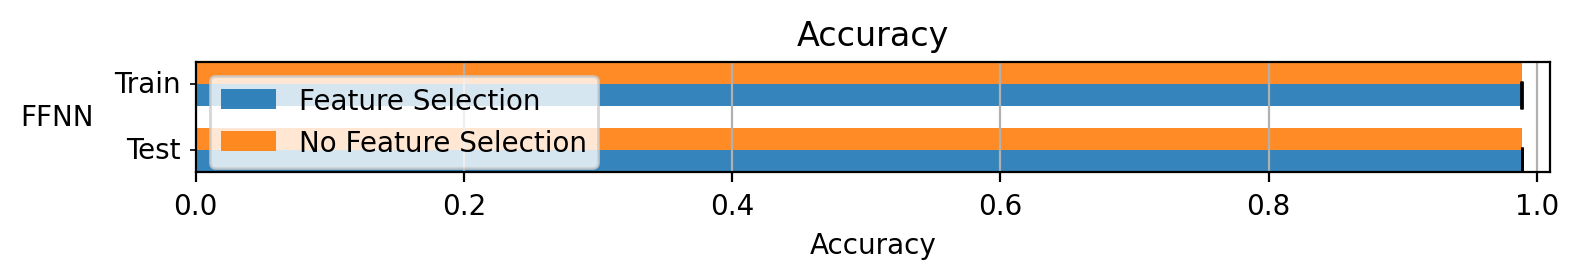

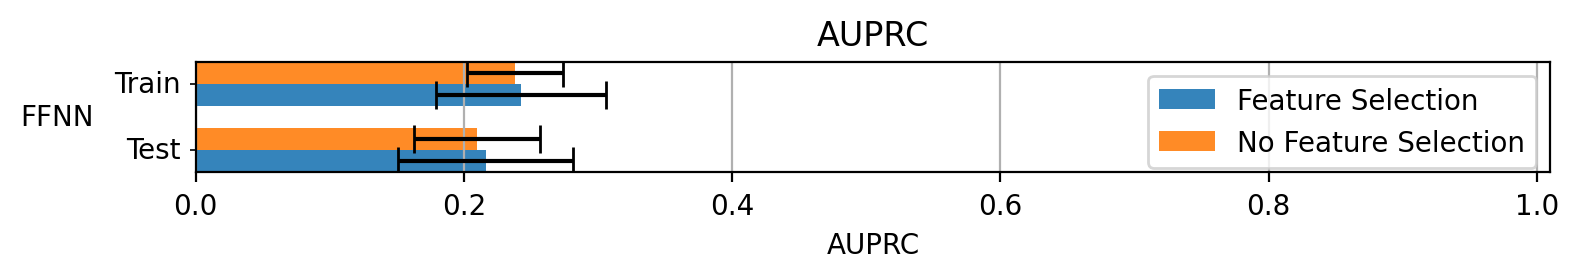

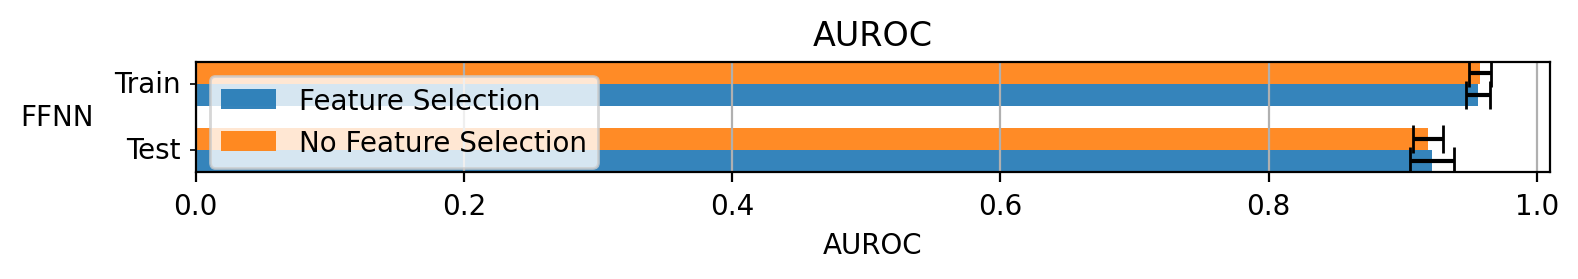

In [ ]:
barplots(
    all_performance,
    groupby=["model_name", "run_type", "use_feature_selection"],
    orientation="horizontal",
    height=8
)
plt.show()

In [ ]:
from scipy.stats import wilcoxon
for model in all_performance.model_name.unique():
    model_performance = all_performance[(all_performance.model_name == model) & (all_performance.run_type == "test")]
    performance_with_feature_selection = model_performance[
        all_performance.use_feature_selection == "Feature Selection"
    ]
    performance_without_feature_selection = model_performance[
        all_performance.use_feature_selection == "No Feature Selection"
    ]

    for metric in ("AUPRC", "AUROC", "Accuracy"):
        print(
            model,
            metric,
            wilcoxon(performance_with_feature_selection[metric], performance_without_feature_selection[metric])
        )

FFNN AUPRC WilcoxonResult(statistic=26.0, pvalue=0.8784817434328712)
FFNN AUROC WilcoxonResult(statistic=18.0, pvalue=0.3328797545683888)
FFNN Accuracy WilcoxonResult(statistic=0.0, pvalue=0.17971249487899976)


<ipython-input-13-161b697bf90a>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  performance_with_feature_selection = model_performance[
<ipython-input-13-161b697bf90a>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  performance_without_feature_selection = model_performance[
E:\anaconda\envs\cazzo_culo\lib\site-packages\scipy\stats\morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
